In [61]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import matplotlib.pyplot as plt
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


bounding_box_dict = dict() #COntain cols 1, 2, 3, 4
{"*.jpeg": [[67, 47, 110, 117], [70, 30, 83, 34], [160, 46, 59, 63]], "*.jpeg"}
label_dict = dict() #COntains dummy variable of strawberry, blackspot
{"*.jpeg": [1, 1, 0, }
Update bouding box then update label in the for loop.
print(strawberry_csv["FreshStrawberries90.jpeg"])

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Baby Dataset Fruit Defects Dataset .zip", 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# import transforms as T

# def get_transform(train):
#     transforms = []
#     transforms.append(T.ToTensor())
#     if train:
#         transforms.append(T.RandomHorizontalFlip(0.5))
#     return T.Compose(transforms)

In [ ]:
# def create_dataframe(image_file_paths):
    
#     classes = ["FreshApples", "FreshBananas", "FreshStrawberries", "RottenApples", "RottenBananas", "RottenStrawberries"]
#     dataframe = pd.DataFrame(image_file_paths, columns = ["image_path"])
#     dataframe["label"] = dataframe.apply(lambda row: classes.index(row["image_path"].rsplit('/', 3)[-3]), axis = 1)
    
#     return dataframe

# #Use glob glob to find pattern in file types to get list of all image paths
# # image_file_paths_train = glob.glob("/content/Fruit Defects Dataset /Train/*/*.jpeg")
# image_file_paths_extra = glob.glob("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/*.jpeg")
# # image_file_paths_test = glob.glob("/content/imagewoof2-160/val/*/*.JPEG")
# fruits_defects_train = create_dataframe(image_file_paths_extra)
# # image_woof_dataframe_test = create_dataframe(image_file_paths_test)
# print(np.unique(fruits_defects_train.label))
# # print(np.unique(image_woof_dataframe_test.label))

[2]


In [ ]:
#Read the Faster-R-CNN thing (https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/)
#Combine all the csv datasets that I have so far
#Get the big csv all in this for loop
#Label more data. 
#Update this data loading
#https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/


## To Do: 
Do research on augmentations 
and decide to fix trainloader. Make my own train loader class if needed. 

* Model: 
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [4]:
#For one strawberry batch please drop watermark rows
strawberry_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 3 Labeled/FreshStrawberryBatch3Labels.csv", header = None)
strawberry_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberriesBatch2Labels.csv", header = None)
strawberry_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/Strawberrybatch1.csv", header = None)
rottenApple_csv_batch_1 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch1Labeled/RottenAppleBatch1Labels.csv", header = None)
rottenApple_csv_batch_2 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch2Labeled/RottenApplesBatch2Labels.csv", header = None)
rottenApple_csv_batch_3 = pd.read_csv("/content/Fruit Defects Dataset /Train/RottenApples/RottenAppleBatch3Labaled/RottenApplesBatch3Labels.csv", header = None)



strawberry_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
strawberry_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_1.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_2.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]
rottenApple_csv_batch_3.columns = ["Fruit", "Coord1", "Coord2", "Coord3", "Coord4", "Image_id", "OneSize", "TwoSize"]

#Drop some watermark data for Fresh StrawBerry Batch 1 Labeled images [59, 9, 93]

# strawberry_csv_batch_1 = strawberry_csv_batch_1[Image_id not in ["FreshStrawberries59.jpeg, FreshStrawberries9.jpeg, FreshStrawberries93.jpeg"]]
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries59.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries9.jpeg"].index, inplace = True)
strawberry_csv_batch_1.drop(strawberry_csv_batch_1[strawberry_csv_batch_1["Image_id"] == "FreshStrawberries93.jpeg"].index, inplace = True)
strawberry_csv_batch_1 = strawberry_csv_batch_1.reset_index(drop=True)

#Stack all the csv files together. 
list_of_all_dataframes = [strawberry_csv_batch_1, strawberry_csv_batch_2, strawberry_csv_batch_3, rottenApple_csv_batch_1, rottenApple_csv_batch_2, rottenApple_csv_batch_3]
fruit_df = pd.concat(list_of_all_dataframes, ignore_index = True)

total_row_sum_check = 0 
for dataframe in list_of_all_dataframes:
  total_row_sum_check += dataframe.shape[0]
print("Checked total rows from all the dataframes combined: {}".format(total_row_sum_check))
assert total_row_sum_check == fruit_df.shape[0]
print("DataFrame shape: {}".format(fruit_df.shape))
print("Unique Fruit Labels {}".format(fruit_df["Fruit"].unique()))
print("Number of Unique Images {}".format(len(fruit_df["Image_id"].unique())))
  


Checked total rows from all the dataframes combined: 526
DataFrame shape: (526, 8)
Unique Fruit Labels ['Strawberry' 'Apples' 'Bad_Spots']
Number of Unique Images 159


In [5]:
bounding_box_dict = dict()
labels_dict = dict()
classes = ["Bad_Spots", "Strawberry", "Apples"]

for row_index in range(len(fruit_df)): 
  current_image_file = fruit_df.iloc[row_index]["Image_id"]
  if current_image_file not in bounding_box_dict:
    bounding_box_dict[current_image_file] = list()
    labels_dict[current_image_file] = list()
  bounding_box_dict[current_image_file].append(fruit_df.iloc[row_index, 1:5].to_list())
  labels_dict[current_image_file].append(classes.index(fruit_df.iloc[row_index, 0]))

print(len(bounding_box_dict))
print(len(labels_dict))

159
159


### Example Pseudo code for an image

For the image below we need 6 bounding boxes for example
Model forms 8. 

https://debuggercafe.com/faster-rcnn-object-detection-with-pytorch/

``` 
labels = ["Badspots", "Apples"]
labels (after processing) = [0, 1]

output = [{"boxes": [[], [], [], [], [], [], [], []],
          "labels": [0, 0, 0, 0, 1, 1, 0, 0, 0] #Predicted 6 bounding boxes and 2 apples. 
          "scores": [0.98, 0.95 ... 0.05 ] #Here we set a threshold so that bounding boxes with low confidence score are discarded.]            
```
The length of bouding box is determined by the batch size          

Then get the category names

```
class_names = ["Bad_Spots", "Apples", "Bananas", "Strawberry"]
```

Model pretrained load only for (Coco) * Important b/c we need to train on our datatset not on the Coco dataset
```
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                    min_size=args['min_size'])
```


In [ ]:
sorted(labels_dict.keys())[20]

'FreshStrawberries37.jpeg'

get a for loop and loop throufh each image key create a new word 
so like 
a then ap then app then appl then apple and check if each word is in the folder name. 

* get the keys of the dictionary and then put in into self.imgs list. 
Now I can use if statements to build the root. 

Now i have a list of keys
So I can access the bouding boxes and the label list using that key

Create a dataframe with image_keys and roots.

## more Psedo code

Use glob glob to find all the image paths then I can say:
[list of of image paths inside Train]

only one file patg that will end FreshStrawberries37.jpeg

for file_path in glob_path:
  if image_key in file_path (get stuff before last backslash): ("Strawberry")
  then return that file_path
  return file_path

## Class function

In [ ]:
"FreshStrawberries37" in glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")[11]
#Image_file_path = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

False

In [ ]:
glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")[10]

'/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 2 Labeled/FreshStrawberries94.jpeg'

In [ ]:
sorted(labels_dict.keys())[:7]

['FreshStrawberries0.jpeg',
 'FreshStrawberries1.jpeg',
 'FreshStrawberries10.jpeg',
 'FreshStrawberries12.jpeg',
 'FreshStrawberries13.jpeg',
 'FreshStrawberries14.jpeg',
 'FreshStrawberries15.jpeg']

In [ ]:
def ffile_path(image_id, full_image_file_paths):
    for image_path in full_image_file_paths:
      if image_id in image_path:
        return image_path

img_path = ffile_path(sorted(labels_dict.keys())[1], glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg"))
img = Image.open(img_path).convert("RGB")

/content/Fruit Defects Dataset /Train/FreshStrawberries/Fresh StrawBerry Batch 1 Labeled/FreshStrawberries1.jpeg


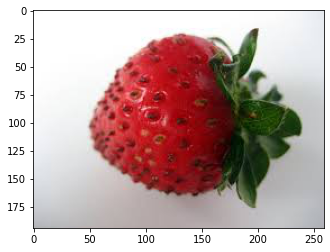

In [ ]:
print(img_path)
plt.imshow(img)

In [ ]:
#[[x axis, y_axis, x_axis, y_axis]]
#Bigger number means to down low and 
#smaller number means up high

In [ ]:
gh = bounding_box_dict[sorted(labels_dict.keys())[11]]
# print([labels_dict[sorted(labels_dict.keys())[1]]])
gh = torch.as_tensor(gh)
gh

tensor([[ 58,  74,  63,  57],
        [125,  66,  69,  85],
        [ 99,  29,  36,  44]])

In [ ]:
some_l = torch.tensor([[ 58,  74,  63,  57],
        [125,  66,  69,  85],
        [ 99,  29,  36,  44]])

In [ ]:
for ii, pair_of_coord in enumerate(some_l): 
  y_coord = some_l[ii, [1, 3]]
  x_coord = some_l[ii, [0, 2]]
  x_coord_diff = torch.max(x_coord) - torch.min(x_coord)
  y_coord_diff = torch.max(y_coord) - torch.min(y_coord)
  area = x_coord_diff * y_coord_diff
  print(area)

tensor(85)
tensor(1064)
tensor(945)


In [ ]:
print((184 - 23) * (199 - 9))
(88) * (166 - 58)
(150 - 81) * (144 - 5)

30590


9591

In [ ]:
print((gh[:, 3] - gh[:, 1]) * (gh[:, 2] - gh[:, 0]))

tensor([30590, -9504])


In [72]:
def ffile_path(image_id, full_image_file_paths):
  for image_path in full_image_file_paths:
    if image_id in image_path:
      return image_path

def find_area_bb(bb_coord):
  for ii, pair_of_coord in enumerate(bb_coord):
    x_coord = bb_coord[ii, [0, 2]]
    y_coord = bb_coord[ii, [1, 3]]
    return ((torch.max(x_coord) - torch.min(x_coord)) * (torch.max(y_coord) - torch.min(y_coord)))

class FruitDetectDataset(object):
  def __init__(self, id_labels, id_bounding_boxes, transforms):

    assert len(id_labels) == len(id_bounding_boxes)
    assert sorted(id_labels.keys()) == sorted(id_bounding_boxes.keys())
    self.imgs_key = sorted(id_labels.keys())
    self.id_labels = id_labels
    self.id_bounding_boxes = id_bounding_boxes
    self.full_image_file_paths = glob.glob("/content/Fruit Defects Dataset /Train/*/*/*.jpeg")

    self.transforms = transforms

  def __getitem__(self, idx):

    img_path = ffile_path(self.imgs_key[idx], self.full_image_file_paths)
    img = Image.open(img_path).convert("RGB")

    boxes = torch.as_tensor(self.id_bounding_boxes[self.imgs_key[idx]], dtype=torch.float32)
    labels = torch.as_tensor(self.id_labels[self.imgs_key[idx]], dtype=torch.int64)
    image_id = torch.tensor([idx])
    area = find_area_bb(boxes)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    
    #Query about transforms for labels of images
    if self.transforms: 
      img = self.transforms(img)
    
    
    return img, target

  def __len__(self):
    return len(self.imgs_key)

In [87]:
def collate_fn(batch):
  return tuple([list(a) for a in zip(*batch)])
    # return tuple(zip(*batch))

np.random.seed(42)
torch.manual_seed(42)
batch_size = 32

train_transform = transforms.Compose([
                                      transforms.RandomHorizontalFlip(0.5), 
                                      transforms.ToTensor()])
                                      


train_dataset = FruitDetectDataset(labels_dict, bounding_box_dict, train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn= collate_fn)

In [108]:
scolor 

array([212.2728734 ,  54.14647322,  46.36536664])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


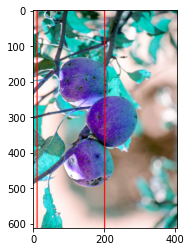

In [136]:
l = cv2.cvtColor(np.asarray(images[0].T), cv2.COLOR_BGR2RGB)
scolor = (255, 0, 0) 
cv2.rectangle(
            l,
            (11, 0),
            (200, 760),
            scolor, 2
        )
plt.imshow(l)

In [67]:
labels[0]

{'area': tensor(33741.), 'boxes': tensor([[  5.,  22., 212., 185.],
         [ 10.,  49.,  78., 146.]]), 'image_id': tensor([152]), 'labels': tensor([2, 0])}

In [133]:
COLORS

array([[180.55850734,   5.24904605, 247.3270123 ],
       [212.2728734 ,  54.14647322,  46.36536664],
       [ 46.76815001,  77.58177195, 133.81289007]])

In [143]:
COLORS = [(255, 0, 0) for i in range(len(classes))]
def draw_boxes(boxes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[labels[i]], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [85]:
COLORS[0]

array([110.14597975,  74.26343075, 156.02248815])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

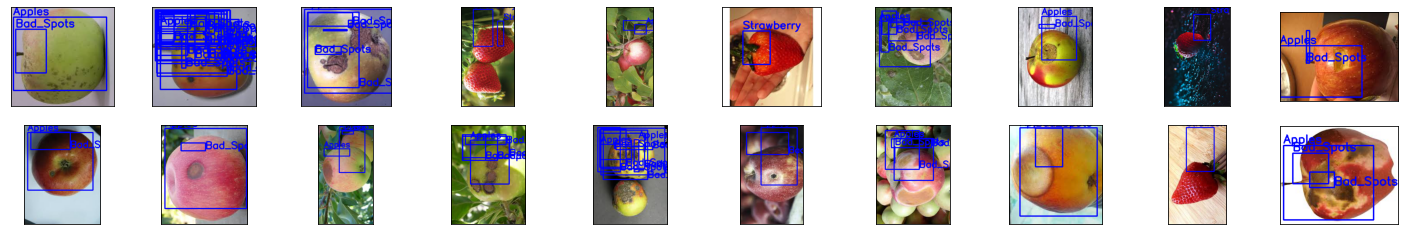

In [144]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = cv2.cvtColor(draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx].T), cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [ ]:

# bounding_box_dict = dict()
# labels_dict = dict()
# classes = ["Black_Spots", "Strawberry"]

# for row_index in range(len(strawberry_csv)): 
#   current_image_file = strawberry_csv.iloc[row_index]["Image_id"]
#   if current_image_file not in bounding_box_dict:
#     bounding_box_dict[current_image_file] = list()
#     labels_dict[current_image_file] = list()
#   bounding_box_dict[current_image_file].append(strawberry_csv.iloc[row_index, 1:5].to_list())
#   labels_dict[current_image_file].append(classes.index(strawberry_csv.iloc[row_index, 0]))

